# LSTM Model for ECG Arrhythmia Classification

This notebook implements a LSTM-based deep learning model to classify ECG signals into different arrhythmia types.

#### Import Required Libraries

### Data Processing and Model Libraries
Importing required libraries for data manipulation, visualization, machine learning, and deep learning:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_recall_fscore_support)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

### Data Loading
Loading preprocessed ECG data from NPZ file, containing features (X) and labels (y)

In [2]:
print("Loading preprocessed data...")
data = np.load('data/ecg_mitdb_processed.npz')
X = data['X']
y = data['y']
label_names = data['label_names']

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Classes: {label_names}")


Loading preprocessed data...
Data shape: X=(112559, 250, 1), y=(112559, 5)
Classes: ['F' 'N' 'Q' 'S' 'V']


### Data Splitting
Splitting data into training, validation, and test sets using a stratified approach to maintain class distribution

In [3]:
print("\nSplitting data...")
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1)
)

# Second split: 80% train, 20% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Splitting data...
Train set: 72037 samples
Validation set: 18010 samples
Test set: 22512 samples


### Model Architecture
Defining a LSTM-based neural network model with dropout layers for regularization

In [4]:
print("\nBuilding LSTM model...")

def create_lstm_model(input_shape, num_classes):
    """
    Create LSTM model for ECG classification

    Args:
        input_shape: Shape of input (timesteps, features)
        num_classes: Number of output classes
    """
    model = models.Sequential([
        # First LSTM layer with return sequences
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        # Third LSTM layer (no return sequences - outputs single vector)
        layers.LSTM(32),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

model = create_lstm_model(input_shape, num_classes)



Building LSTM model...


c:\Users\indra\anaconda3\envs\myenv39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

In [6]:
import shutil
print("Graphviz dot path:", shutil.which("dot"))


Graphviz dot path: C:\Program Files\Graphviz\bin\dot.EXE


In [ ]:
from tensorflow.keras.utils import plot_model

print("Model summary:")
model.summary()

# Save summary to a text file
summary_path = "model_summary.txt"
with open(summary_path, "w") as f:
    model.summary(print_fn=lambda line: f.write(line + "\n"))
print(f"Saved textual model summary to: {summary_path}")

# to save a visual diagram
plot_path = "model_structure.png"
try:
    plot_model(
        model,
        to_file=plot_path,
        show_shapes=True,
        show_layer_names=True,
        dpi=96,
    )
    print(f"Saved model diagram to: {plot_path}")
except Exception as e:
    print("Could not save with plot_model().")
    print("Reason:", e)
    print("To enable plotting, install pydot and graphviz, for example:")
    print("  pip install pydot graphviz")
    #if getting any error then install graphviz from chrome

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 250, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,165 (360.02 KB)

 Trainable params: 91,845 (358.77 KB)

 Non-trainable params: 320 (1.25 KB)

Saved textual model summary to: model_summary.txt
Saved model diagram to: model_structure.png


In [ ]:
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=1
)


### Model Training
Training the LSTM model with Adam optimizer and monitoring multiple metrics


Plotting training history...
Training history saved to: training_history.png


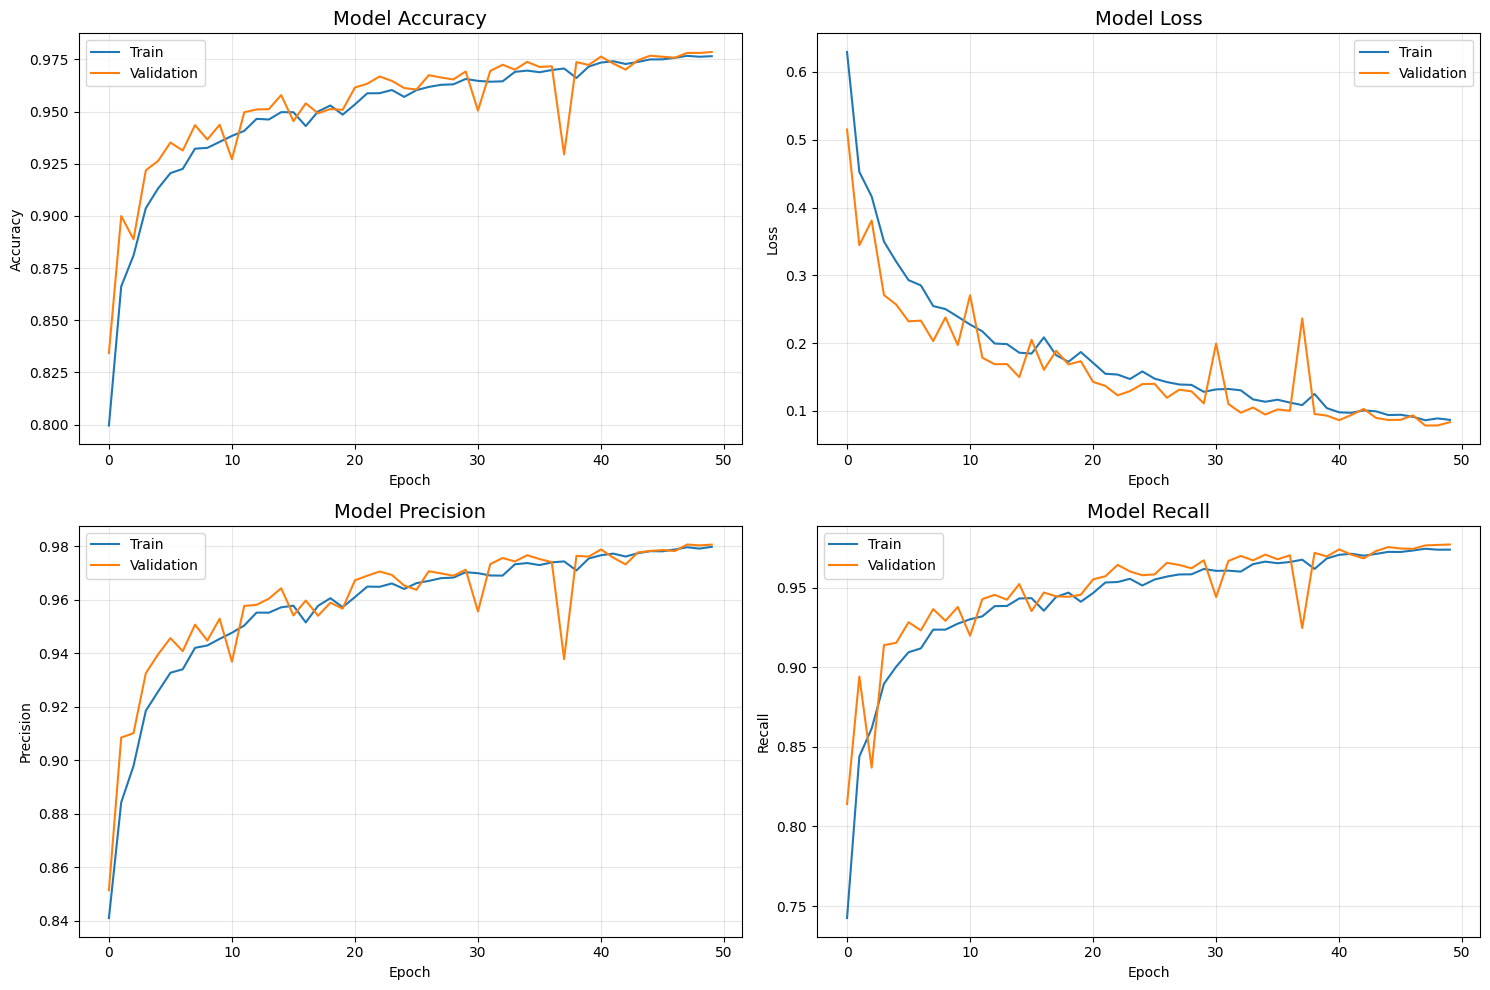

In [ ]:
print("\nPlotting training history...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy', fontsize=14)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss', fontsize=14)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Validation')
axes[1, 0].set_title('Model Precision', fontsize=14)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Validation')
axes[1, 1].set_title('Model Recall', fontsize=14)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
print("Training history saved to: training_history.png")
plt.show()


### Training Visualization
Plotting training metrics (accuracy, loss, precision) to evaluate model performance

In [ ]:
print("\n" + "="*70)
print("EVALUATION ON TEST SET")
print("="*70)

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("\nPer-Class Detailed Metrics:")
print("-" * 70)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i, label in enumerate(label_names):
    print(f"{label:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")



EVALUATION ON TEST SET
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

Test Loss: 0.0867
Test Accuracy: 0.9773
Test Precision: 0.9791
Test Recall: 0.9759

Classification Report:
              precision    recall  f1-score   support

           F     0.8175    0.6438    0.7203       160
           N     0.9842    0.9940    0.9890     18119
           Q     0.9575    0.9700    0.9637      2230
           S     0.9199    0.7644    0.8350       556
           V     0.9531    0.8991    0.9253      1447

    accuracy                         0.9773     22512
   macro avg     0.9264    0.8542    0.8867     22512
weighted avg     0.9767    0.9773    0.9767     22512


Per-Class Detailed Metrics:
----------------------------------------------------------------------
Class      Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
F          0.8175       0.6438       0.7203       160       
N          0.9842       0.9940       0.9890  


Generating confusion matrix...
Confusion matrix saved to: confusion_matrix.png


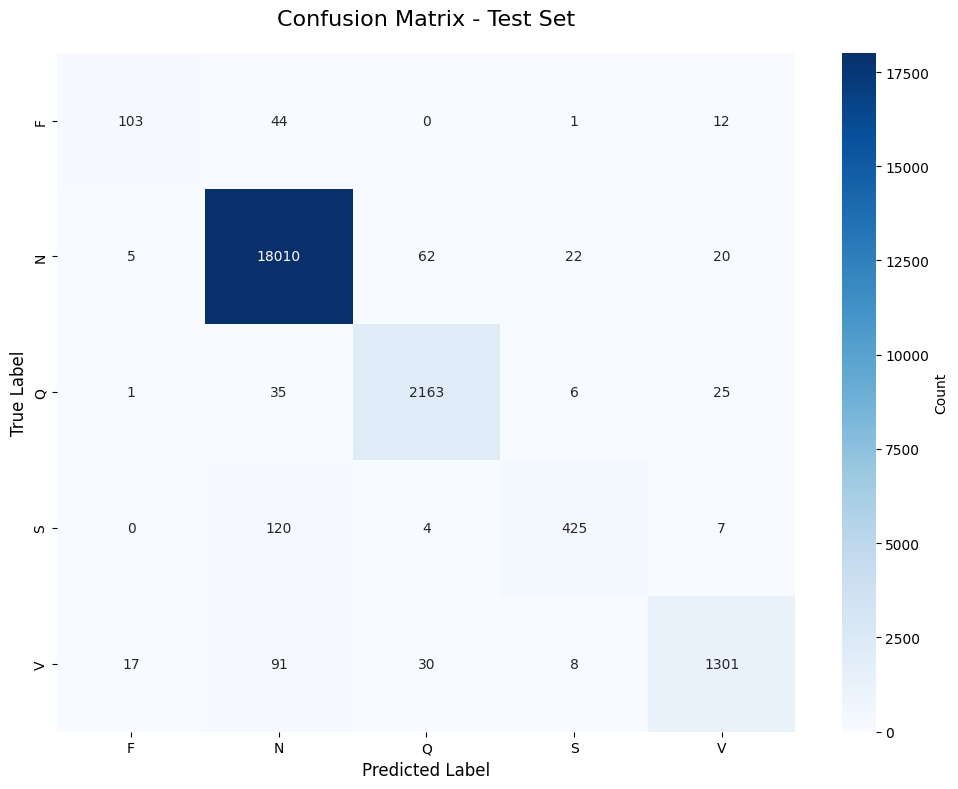

Normalized confusion matrix saved to: confusion_matrix_normalized.png


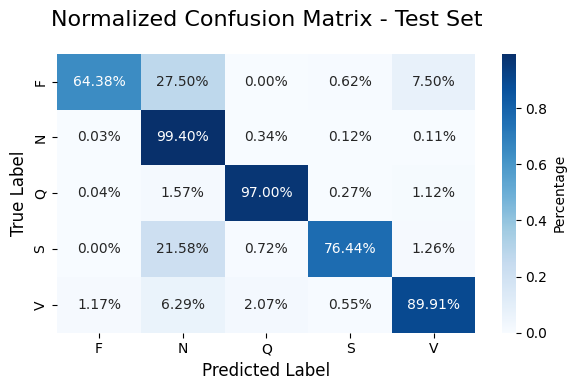

In [ ]:
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("Confusion matrix saved to: confusion_matrix.png")
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
print("Normalized confusion matrix saved to: confusion_matrix_normalized.png")
plt.show()



Visualizing sample predictions...
Sample predictions saved to: sample_predictions.png


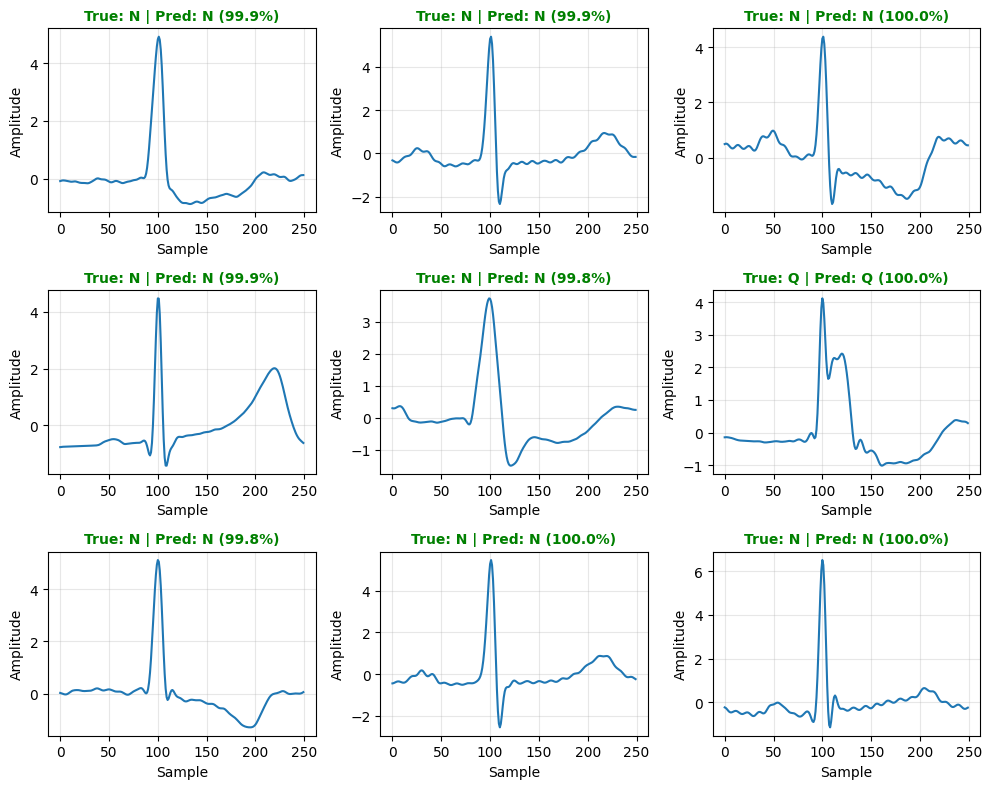

In [ ]:
print("\nVisualizing sample predictions...")
num_samples = min(9, len(X_test))
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100

    axes[i].plot(X_test[idx, :, 0])

    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label} | Pred: {pred_label} ({confidence:.1f}%)',
                     color=color, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Sample')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
print("Sample predictions saved to: sample_predictions.png")
plt.show()